# Цель работы- разделить данные на кластеры
## Кластеры будут содержать миллиардеров с похожими данными о себе, возможно это поможет тем, кто анализирует данные об этих людях

# Загрузка датасета 

In [1]:
import pandas as pd
df = pd.read_csv("C://Users//annal//aim//static//csv//Forbes_Billionaires.csv")
df

Rank                        Name  Networth  Age        Country  \
0         1                 Elon Musk      219.0   50  United States   
1         2                Jeff Bezos      171.0   58  United States   
2         3  Bernard Arnault & family      158.0   73         France   
3         4                Bill Gates      129.0   66  United States   
4         5            Warren Buffett      118.0   91  United States   
...     ...                        ...       ...  ...            ...   
2595   2578    Jorge Gallardo Ballart        1.0   80          Spain   
2596   2578              Nari Genomal        1.0   82    Philippines   
2597   2578            Ramesh Genomal        1.0   71    Philippines   
2598   2578            Sunder Genomal        1.0   68    Philippines   
2599   2578     Horst-Otto Gerberding        1.0   69        Germany   

                      Source                Industry  
0              Tesla, SpaceX             Automotive   
1                     Amazon             Technology   
2                       LVMH       Fashion & Retail   
3                  Microsoft             Technology   
4         Berkshire Hathaway  Finance & Investments   
...                      ...                     ...  
2595         pharmaceuticals             Healthcare   
2596                 apparel       Fashion & Retail   
2597                 apparel       Fashion & Retail   
2598                garments       Fashion & Retail   
2599  flavors and fragrances        Food & Beverage   

[2600 rows x 7 columns]

# Подготовим данные. Удалим неинформативные столбцы, преобразуем категориальные столбцы в числовые и нормализуем

In [2]:
# Удаляем неинформативные столбцы
df = df.drop(columns=["Rank ", "Name"])

# Преобразование категориальных данных в числовые с помощью one-hot encoding
df = pd.get_dummies(df, drop_first=True)

# Нормализация числовых данных
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Визуализируем данные при помощи PCA
## Метод PCA уменьшает количество измерений до двух, но сохраняет максимально возможное количество информации. Он находит новые оси в данных и потом проецирует их на эти оси. Вдоль этих осей разброс данных максимальный

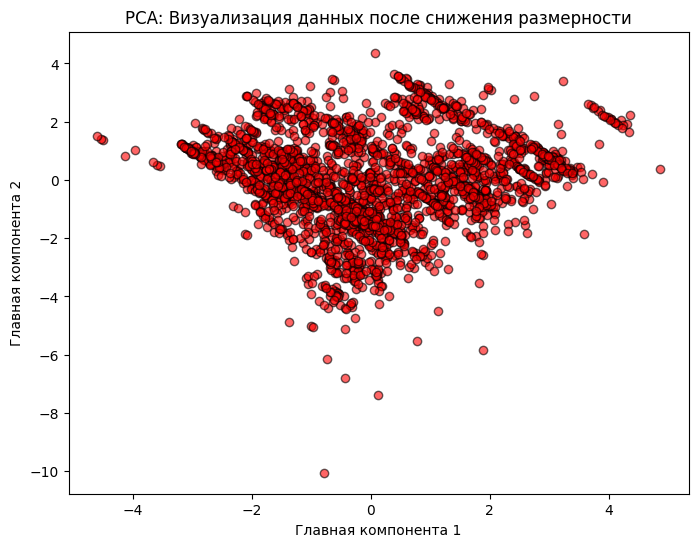

In [3]:
# Импортируем PCA и визуализируем данные
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Применяем PCA для снижения размерности до 2
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Визуализация
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c='red', edgecolor='k', alpha=0.6)
plt.title("PCA: Визуализация данных после снижения размерности")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.show()

# Определим количество кластеров
## Это важно, потому что оптимальное количество кластеров позволит разделить данные так, чтобы не были упущенны важные моменты. Кроме того, это сделает данные понятными и полезными, повлияет и на способность обощения модели. Если кластеров слишком много, то модель будет обращать излишнее внимание на шум, если кластеров слишком мало, то модель будет игнорировать важные моменты

# Для разделения на кластеры воспользуемся методом локтя и коэффициентом силуэта
## Метод локтя измеряет инерцию, то есть размерность ошибок внутри кластеров. Инерция — это сумма квадратов расстояний от точек до центроидов их кластеров. Чем меньше будет значение, тем лучше
## Коэффициет силуэта покажет, насколько хорошо распределены объекты по кластерам. Он оценивает плотность кластеров и принимает значения от -1 до 1. Чем ближе результат к 1, тем лучше.

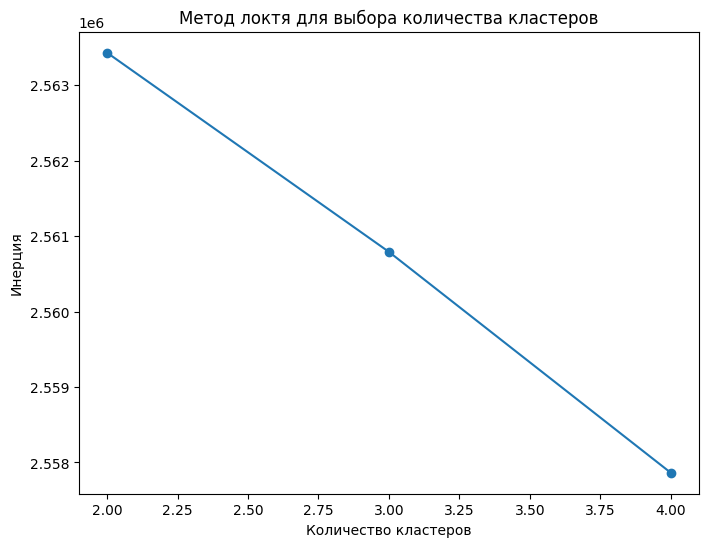

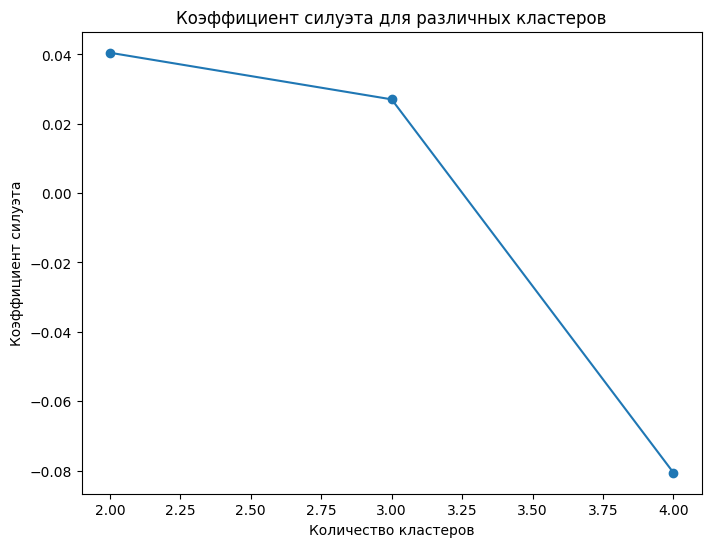

In [30]:
# Метод локтя
from sklearn.cluster import KMeans

border_l = 2
border_r = 5

inertia = []
for k in range(border_l, border_r):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Визуализация метода локтя
plt.figure(figsize=(8, 6))
plt.plot(range(border_l, border_r), inertia, marker='o')
plt.title('Метод локтя для выбора количества кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.show()

# Коэффициент силуэта
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(border_l, border_r):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    score = silhouette_score(df_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Визуализация коэффициента силуэта
plt.figure(figsize=(8, 6))
plt.plot(range(border_l, border_r), silhouette_scores, marker='o')
plt.title('Коэффициент силуэта для различных кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.show()


# Кластеризируем с помощью K-means
## K-means — это алгоритм кластеризации, который группирует данные вокруг центров (центроидов) кластеров. Я выбираю количество кластеров, равное 2, исходя из коэффициента силуэта на диаграмме выше

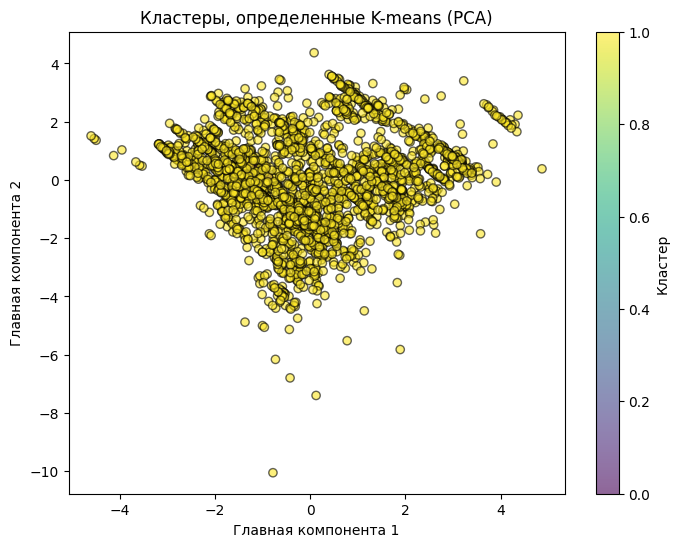

In [28]:
# Кластеризация с помощью K-means
optimal_clusters = 2
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Визуализация кластеров с использованием PCA
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df['Cluster'], cmap='viridis', edgecolor='k', alpha=0.6)
plt.title("Кластеры, определенные K-means (PCA)")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.colorbar(label='Кластер')
plt.show()

# Приступим к иерархической кластеризации
## Иерархическая кластеризация — метод, который строит древовидную структуру кластеров (дендрограмму). Применим её для сравнения с K-means

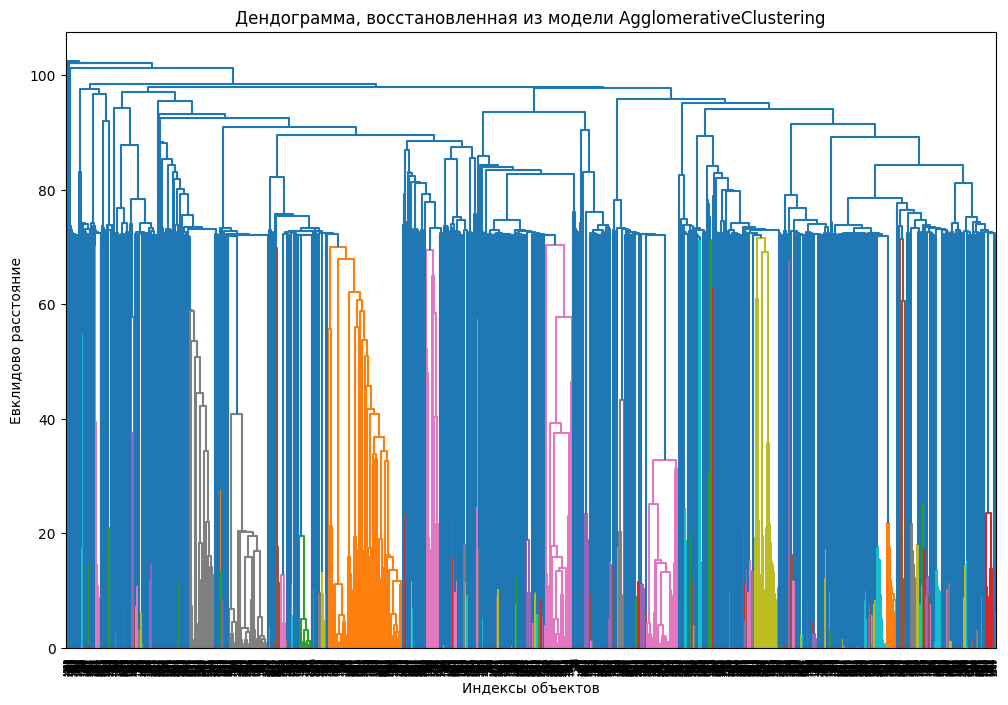

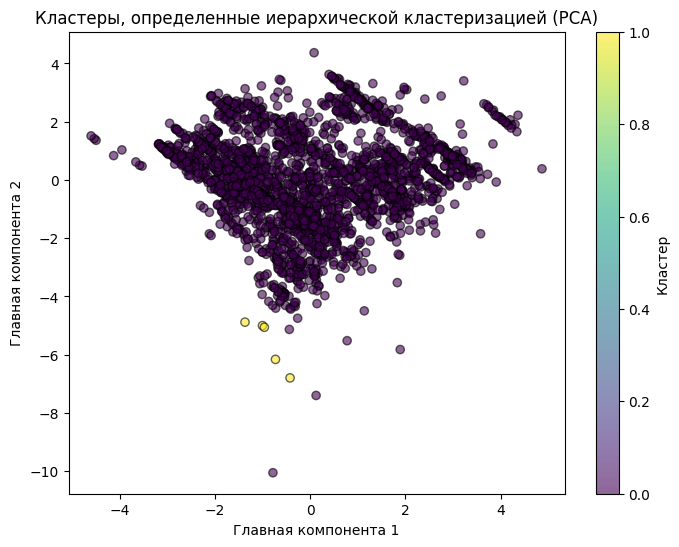

In [29]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import numpy as np
import matplotlib.pyplot as plt

# Применение иерархической кластеризации
hierarchical = AgglomerativeClustering(n_clusters=optimal_clusters, compute_distances=True)
df['Hierarchical Cluster'] = hierarchical.fit_predict(df_scaled)

# Функция для получения матрицы linkage
def get_linkage_matrix(model: AgglomerativeClustering) -> np.ndarray:
    counts = np.zeros(model.children_.shape[0])  # type: ignore
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):  # type: ignore
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    return np.column_stack([model.children_, model.distances_, counts]).astype(float)

# Построение дендрограммы
linkage_matrix = get_linkage_matrix(hierarchical)
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix)
plt.title("Дендограмма, восстановленная из модели AgglomerativeClustering")
plt.xlabel("Индексы объектов")
plt.ylabel("Евклидово расстояние")
plt.show()


# Визуализация кластеров
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df['Hierarchical Cluster'], cmap='viridis', edgecolor='k', alpha=0.6)
plt.title("Кластеры, определенные иерархической кластеризацией (PCA)")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.colorbar(label='Кластер')
plt.show()

# Оценим коэффициенты силуэтов двух методов кластеризации

In [31]:
# Оценка качества
silhouette_kmeans = silhouette_score(df_scaled, df['Cluster'])
silhouette_hierarchical = silhouette_score(df_scaled, df['Hierarchical Cluster'])

print(f"Коэффициент силуэта для K-means: {silhouette_kmeans:.4f}")
print(f"Коэффициент силуэта для иерархической кластеризации: {silhouette_hierarchical:.4f}")

Коэффициент силуэта для K-means: 0.0405
Коэффициент силуэта для иерархической кластеризации: 0.3230


# Из полученных данных видно, что коэффициент силуэта для иерархической кластеризации лучше, он ближе к 1. А вот результат для K-means значительно хуже. Границы кластеров размыты сильнее, чем в иерархическом методе. В ходе экспериментов с количеством кластеров для k-meansвыяснилосб, что 0.0405- лучшее значение